# import, data read

In [2]:
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-20T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'],unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close').resample('10min').last()

In [4]:
df_close.mean().sort_values()[-10:]

symbol
AUTOUSDT      233.493750
BNBUSDT       265.583333
BIFIUSDT      345.340278
MKRUSDT       624.076389
YFIIUSDT      867.563889
ETHUSDT      1336.274097
PAXGUSDT     1661.451389
YFIUSDT      8373.729167
BTCUSDT     19049.317500
WBTCBUSD    19053.174514
dtype: float64

In [5]:
symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
df_close_symbols = df_close[symbols]

In [6]:
df_close_symbols

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,834.2,1300.92,1659.0,340.1,262.3
2022-09-19 04:10:00,834.6,1303.61,1659.0,340.1,262.3
2022-09-19 04:20:00,835.4,1303.85,1660.0,343.0,261.9
2022-09-19 04:30:00,835.0,1304.09,1659.0,341.3,261.3
2022-09-19 04:40:00,837.4,1305.19,1659.0,341.7,261.3
...,...,...,...,...,...
2022-09-20 03:10:00,879.8,1349.10,1666.0,345.6,268.2
2022-09-20 03:20:00,874.4,1344.29,1666.0,344.5,267.9
2022-09-20 03:30:00,879.8,1349.84,1667.0,344.6,268.6


# Sanity check: eigen values, vectors

In [240]:
eiven_vals, eigen_vecs = np.linalg.eig([[1, 2, 0], [2, 1, 0], [0, 0, 4]])

In [190]:
eiven_vals

array([ 3., -1.,  4.])

In [191]:
eigen_vecs

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [193]:
eigen_vecs[:,0]

array([0.70710678, 0.70710678, 0.        ])

note that the matrix represenation is bit confusing. v[i,:] is *not* eigenvector, but v[:,i] is.

In [194]:
eigen_vecs[0]

array([ 0.70710678, -0.70710678,  0.        ])

and accordingly the eigenvalues matix on the rhs is to be horizontally layed down.

In [195]:
eigen_vecs @ np.diag(eiven_vals) @ eigen_vecs.T

array([[1., 2., 0.],
       [2., 1., 0.],
       [0., 0., 4.]])

# Solve the minimal predictability condition

In [7]:
df_close_symbols.corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
symbol,,,,,
YFIIUSDT,1.000000,0.950428,0.818159,0.932186,0.927611
ETHUSDT,0.950428,1.000000,0.921066,0.945962,0.968835
PAXGUSDT,0.818159,0.921066,1.000000,0.831618,0.920978
BIFIUSDT,0.932186,0.945962,0.831618,1.000000,0.939282
BNBUSDT,0.927611,0.968835,0.920978,0.939282,1.000000


In [8]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    return 1 / (m - lag - 1) * (arr[lag:] - np.nanmean(arr[lag:], axis=0)).T @ (arr[:m-lag] - np.nanmean(arr[:m-lag], axis=0))

In [9]:
cov_matrix = df_close_symbols.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)
inv_sqrt_cov_matrix = scipy.linalg.sqrtm(inv_cov_matrix)
autocov_matrix = calc_autocov_matrix(df_close_symbols.values, 1)

In [10]:
var_predictability_matrix = inv_sqrt_cov_matrix @ autocov_matrix @ cov_matrix @ autocov_matrix.T @ inv_sqrt_cov_matrix.T

In [11]:
var_predictability_matrix

,0,1,2,3,4
0,360412.639941,6.501395e+05,124879.137911,101684.567775,116370.738928
1,650139.477194,1.174864e+06,225979.552748,183572.374245,210218.048724
2,124879.137911,2.259796e+05,43516.495646,35281.358132,40424.948914
3,101684.567775,1.835724e+05,35281.358132,28699.853271,32853.408180
4,116370.738928,2.102180e+05,40424.948914,32853.408180,37618.550970


In [12]:
var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability_matrix)

asc = np.argsort(var_eigen_vals)
var_eigen_vals, var_eigen_vecs = var_eigen_vals[asc], var_eigen_vecs[:, asc]

In [14]:
var_eigen_vals

array([9.19895306e-02, 1.55701334e+00, 4.41433088e+00, 5.74653524e+02,
       1.64453118e+06])

In [27]:
var_eigen_vecs[:,0]

array([-0.03770649,  0.09883495, -0.39913313, -0.6893261 ,  0.59525805])

# Portfolio graphs

In [33]:
df_close_symbols.tail(3)

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-20 03:30:00,879.8,1349.84,1667.0,344.6,268.6
2022-09-20 03:40:00,880.4,1353.94,1667.0,344.6,269.3
2022-09-20 03:50:00,883.4,1354.29,1667.0,347.5,269.2


<Axes: xlabel='time'>

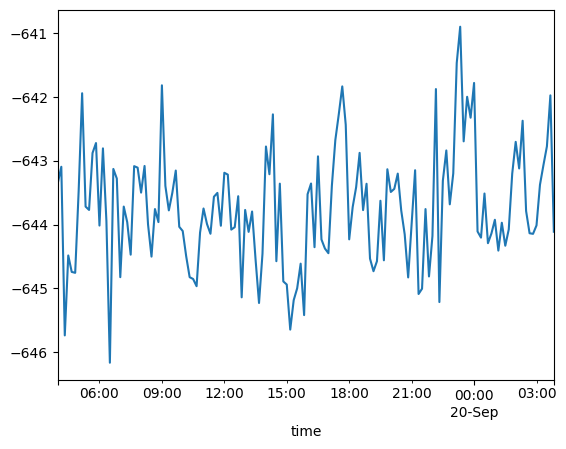

In [29]:
((df_close_symbols) * var_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

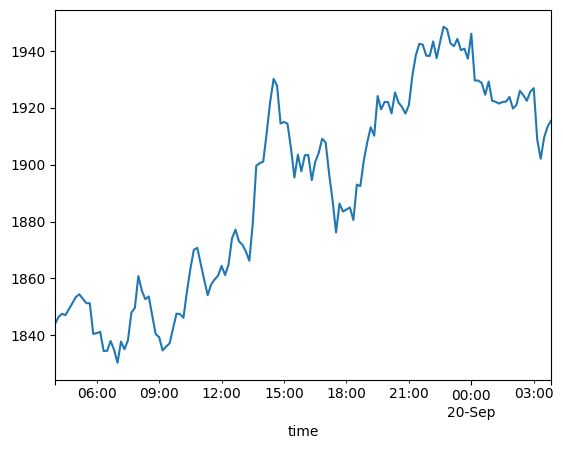

In [30]:
((df_close_symbols) * var_eigen_vecs[:,-1]).sum(axis=1).plot()

<Axes: xlabel='time'>

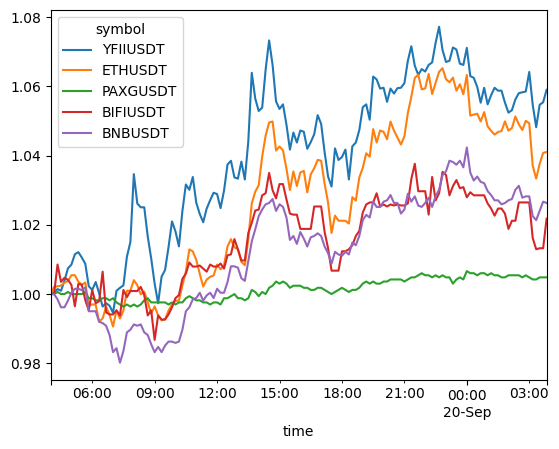

In [26]:
(df_close_symbols / df_close_symbols.iloc[0]).plot()

# rolling based

In [20]:
df_close_symbols.rolling(60).corr()

symbol                        YFIIUSDT   ETHUSDT  PAXGUSDT  BIFIUSDT   BNBUSDT
time                symbol                                                    
2022-09-19 04:00:00 YFIIUSDT       NaN       NaN       NaN       NaN       NaN
                    ETHUSDT        NaN       NaN       NaN       NaN       NaN
                    PAXGUSDT       NaN       NaN       NaN       NaN       NaN
                    BIFIUSDT       NaN       NaN       NaN       NaN       NaN
                    BNBUSDT        NaN       NaN       NaN       NaN       NaN
...                                ...       ...       ...       ...       ...
2022-09-20 03:50:00 YFIIUSDT  1.000000  0.919561  0.614003  0.810069  0.784543
                    ETHUSDT   0.919561  1.000000  0.715268  0.838808  0.833300
                    PAXGUSDT  0.614003  0.715268  1.000000  0.493253  0.714735
                    BIFIUSDT  0.810069  0.838808  0.493253  1.000000  0.701994
                    BNBUSDT   0.784543  0.833300  0.714735  0.701994  1.000000

[720 rows x 5 columns]